In [1]:
import numpy as np
from scipy.constants import N_A
from matplotlib import pyplot as plt
from colloids import phase
%matplotlib inline

All datafiles are calculated supposing a radius of 5.365 px ($\sigma = 2.1\,\mu m$) as given by the first peak of $g(r)$. However this underestimates volume fractions, as show by time evolution of local volume fraction of 12-neighboured particles, by local volume fractions function of number of neighbours and by binodal compositions obtained by Gaussian analysis.

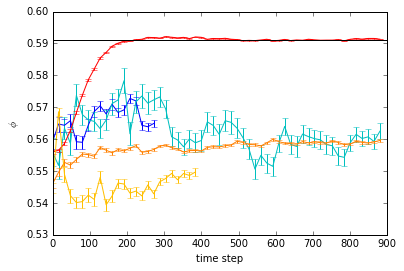

In [2]:
colors = ['b', 'c', 'r', (1,0.5,0), (1,0.75,0), (0.5,0,0), (0,0.5,0)]
av = 16
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    t, phi, err = np.loadtxt('data/newmediaphi_phi0.%d_cp%0.2f'%(p,c), unpack=True)
    nl = len(phi)//av
    nphi = (phi/err**2)[:av*nl].reshape((nl,av)).sum(1) / (1/err**2)[:av*nl].reshape((nl,av)).sum(1)
    nerr = (1/err**2)[:av*nl].reshape((nl,av)).sum(1)**(-0.5)
    plt.errorbar(t[:nl*av:av], nphi, nerr, color=col)
#plt.xlim(0,400)
plt.axhline(0.591, c='k')
plt.xlabel('time step')
plt.ylabel(r'$\phi$')

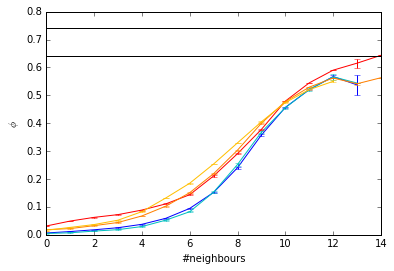

In [3]:
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    plt.errorbar(*np.loadtxt('data/vol_err_phi_0.%d_cp_%0.2f'%(p,c), unpack=True), color=col)
plt.axhline(0.64, color='k')
plt.axhline(0.74, color='k')
plt.xlabel('#neighbours')
plt.ylabel(r'$\phi$')

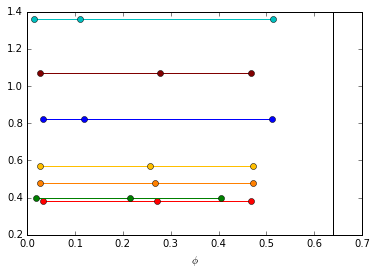

In [4]:
for (cp, phiG, phi, phiL), col in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors):
    plt.plot(np.array([phiG, phi, phiL]), [cp]*3, 'o-', color=col)
plt.axvline(0.64, c='k')
plt.xlabel(r'$\phi$')

In free volume theory, the metastable gas-liquid critical point is at a polymer concentration where the equilibrium crystal volume fraction is 0.723. This should be the final local volume fraction of the 12-neighboured particles in our crystallising sample. Therefore, we will scale all volume fractions by

In [5]:
#mulphi = 0.723/np.loadtxt('data/vol_err_phi_0.%d_cp_%0.2f'%(25,0.38))[12,1]
mulphi = 0.723/np.loadtxt('data/newmediaphi_phi0.%d_cp%0.2f'%(25,0.38),usecols=[1])[300:].mean()
print('sigma=%0.2f µm'%(2.1 * mulphi**(1/3)))

sigma=2.25 µm


Draw and save scaled local volume fractions of 12-neighboured particles.

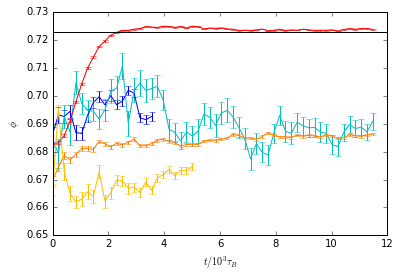

In [6]:
av = 16
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    t, phi, err = np.loadtxt('data/mediaphi_phi0.%d_cp%0.2f'%(p,c), unpack=True)
    phi *= mulphi
    err *= mulphi
    nl = len(phi)//av
    nphi = (phi/err**2)[:av*nl].reshape((nl,av)).sum(1) / (1/err**2)[:av*nl].reshape((nl,av)).sum(1)
    nerr = (1/err**2)[:av*nl].reshape((nl,av)).sum(1)**(-0.5)
    plt.errorbar(t[:nl*av:av]*30/2.3e3, nphi, nerr, color=col)
    np.savetxt(
        'data/mediaphi_phi0.%d_cp%0.2f.scaled'%(p,c), 
        np.column_stack((t[:nl*av:av]*30/2.3e3, 100*nphi, 100*nerr)), 
        header='t_1000tB\tphi\terr', comments='')
#plt.xlim(0,400)
plt.axhline(0.723, c='k')
plt.xlabel(r'$t/10^3\tau_B$')
plt.ylabel(r'$\phi$')

Draw and save scaled local volume fractions function of the number of neighbours.

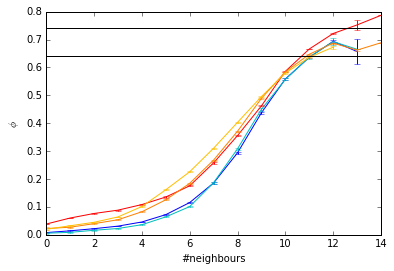

In [7]:
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    n, phi, err = np.loadtxt('data/vol_err_phi_0.%d_cp_%0.2f'%(p,c), unpack=True)
    phi *= mulphi
    err *= mulphi
    plt.errorbar(n, phi, err, color=col)
    np.savetxt(
        'data/vol_err_phi_0.%d_cp_%0.2f.scaled'%(p,c), 
        np.column_stack((n, 100*phi, 100*err)), 
        header='n\tphi\terr\n', comments='')
plt.axhline(0.64, color='k')
plt.axhline(0.74, color='k')
plt.xlabel('#neighbours')
plt.ylabel(r'$\phi$')

Non crystallising samples have local volume fraction above random close packing 0.64. Still the crystallizing sample is above.

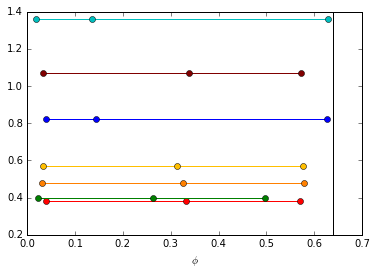

In [8]:
for (cp, phiG, phi, phiL), col in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors):
    plt.plot(mulphi*np.array([phiG, phi, phiL]), [cp]*3, 'o-', color=col)
plt.axvline(0.64, c='k')
plt.xlabel(r'$\phi$')

The liquid binodal is close and below radom close packing for all samples.

Draw the experimental compositions and try to adjust the polymer size to get the binodal at the gel boundary.

In [9]:
def getGLspxp(sigma, R, Mw=3.6e6, d=1.24, fluid=phase.CarnahanStarling()):
    """Fast gas spinodal computation"""
    qR = 2*R/sigma
    cpov = 1000 * (3 * Mw)/(4 * np.pi * (R*1e-9)**3 * N_A * d*1e6)
    q = phase.qR2q(qR)
    GL = fluid.spinodalGL(q)
    return [(phase.f2vf(f), phase.piv2y(GL[:,0], qR) * phase.alpha(f, q) * cpov) for f in GL.T[1:]]

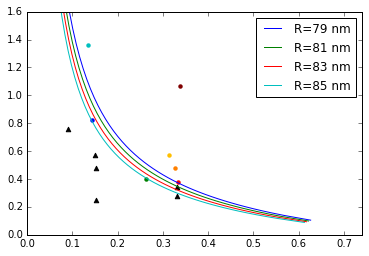

In [10]:
phixpF = np.array([0.141, 0.141, 0.139, 0.084, 0.307, 0.309])/(5.6/5.365)**3*mulphi
cpxpF = np.array([0.25,0.48,0.57, 0.76, 0.28, 0.34])

plt.scatter(phixpF, cpxpF, c='k', marker='^')
for (cp, phi), col in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1, usecols=[0,2]), colors):
    plt.scatter(phi*mulphi, cp, c=col, marker='o', lw=0)

for R in range(79,86,2):
    for x,y in getGLspxp(sigma=2.1e3 * mulphi**(1/3), R=float(R))[:1]:
        plt.plot(x,y,label='R=%d nm'%R)
    
plt.xlim(0,0.74)
plt.ylim(0,1.6)
plt.legend(loc='upper right')

The best polymer radius of gyration is 80 nm. Compute the theoretical phase diagram accordingly.

In [11]:
R = 80
sigma = 2.1e3 * mulphi**(1/3)
Mw=3.6e6
d=1.24
qR = 2*R/sigma
cpov = 1000 * (3 * Mw)/(4 * np.pi * (R*1e-9)**3 * N_A * d*1e6)
q = phase.qR2q(qR)
print('qR = %0.3f, q = %0.3f, Cov = %0.3f mg/g'%(qR, q, cpov))

#gas-liquid binodal and spinodal
GL = phase.Liu().all_GL(q, maxpiv=2400)
    
#fluid-crystal coexistence
FS = phase.all_coexistence(q, phase.Liu(), phase.Hall(), maxpiv=2400)

qR = 0.071, q = 0.075, Cov = 2.248 mg/g


In [12]:
def xp2th(cp, phi, qR=0.1, cpov=1.):
    """Converts experimental polymer concentration in osmotic pressure"""
    return phase.y2piv(cp / cpov / phase.alpha(phase.vf2f(phi), phase.qR2q(qR)), qR)

(0, 2400)

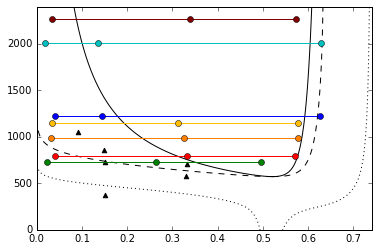

In [14]:
#draw and save theoretical lines
for f,l, ph in zip(GL.T[1:], ['--']*2+['-']*2, ['bg', 'bl', 'sg', 'sl']):
    plt.plot(phase.f2vf(f), GL[:,0], 'k'+l)
    np.savetxt(
        'res_gasliquid_%s.phd'%ph,
        np.column_stack((phase.f2vf(f), GL[:,0])),
        header='phi\tPiv',
        )
for f, ph in zip(FS.T[1:], 'fx'):
    plt.plot(phase.f2vf(f), FS[:,0], 'k:')
    np.savetxt(
        'res_fluidcrystal_%s.phd'%ph,
        np.column_stack((phase.f2vf(f), FS[:,0])),
        header='phi\tPiv',
        )
    
#experimental fluid points
plt.scatter(phixpF, xp2th(cpxpF, phixpF, qR, cpov), c='k', marker='^')
np.savetxt(
    'res_fluid_samples.phd', 
    np.column_stack((phixpF, xp2th(cpxpF, phixpF, qR, cpov))), 
    header='phi\tPiv', fmt='%0.3f'
)

#phase separating points
for (cp, phiG, phi, phiL), col,s in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors, range(7)):
    piv = xp2th(cp, phi*mulphi, qR, cpov)
    plt.plot(np.array([phiG, phi, phiL])*mulphi, [piv]*3, '-o', color=col)
    np.savetxt(
        'res_sample%d.phd'%s, 
        np.column_stack((np.array([phiG, phi, phiL])*mulphi, [piv]*3)), 
        header='phi\tPiv', fmt='%0.3f'
    )

plt.xlim(0,0.74)
plt.ylim(0,2400)

Cross-check that the  coexisting crystal is indeed at 0.723

In [28]:
cp, phiG, phi, phiL = np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1)[2]
piv = xp2th(cp, phi*mulphi, qR, cpov)
phase.f2vf(FS[np.where(FS[:,0]>piv)[0][0],1:])

array([  4.49895076e-05,   7.22783040e-01])

Draw the phase diagram in experimental variables

(0, 1.9)

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


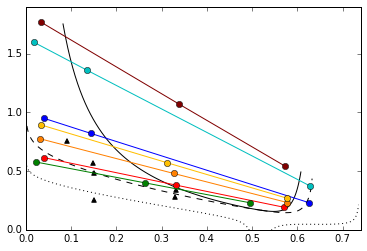

In [30]:
#draw and save theoretical lines
for f,l,ph in zip(GL.T[1:], ['--']*2+['-']*2, ['bg', 'bl', 'sg', 'sl']):
    phis = phase.f2vf(f)
    cps = phase.piv2y(GL[:,0], qR) * phase.alpha(f, q) * cpov
    plt.plot(phis, cps, 'k'+l)
    np.savetxt(
        'gasliquid_%s.phd'%ph,
        np.column_stack((phis, cps)),
        header='phi\tcp',
        )
    
for f, ph in zip(FS.T[1:], 'fx'):
    phis = phase.f2vf(f)
    cps = phase.piv2y(FS[:,0], qR) * phase.alpha(f, q) * cpov
    plt.plot(phis, cps, 'k:')
    np.savetxt(
        'fluidcrystal_%s.phd'%ph,
        np.column_stack((phis, cps)),
        header='phi\tcp',
        )

#experimental fluid points
plt.scatter(phixpF, cpxpF, c='k', marker='^')
np.savetxt('fluid_samples.phd', np.column_stack((phixpF, cpxpF)), header='phi\tcp', fmt='%0.3f')

#phase separating points
for (cp, phiG, phi, phiL), col, s in zip(
    np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), 
    colors, range(7)
):
    phis = np.array([phiG, phi, phiL])*mulphi
    piv = xp2th(cp, phis[1], qR, cpov)
    cps = phase.piv2y(piv, qR) * phase.alpha(phase.vf2f(phis), q) * cpov
    plt.plot(phis, cps, '-o', color=col)
    np.savetxt('sample%d.phd'%s, np.column_stack((phis, cps)), header='phi\tcp', fmt='%0.3f')
plt.xlim(0,0.74)
plt.ylim(0,1.9)

Time evolution of the volume fraction of 12-neighboured particles.

In [32]:
np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1, usecols=[2])*mulphi

array([ 0.14427196,  0.13449081,  0.3325591 ,  0.32644588,  0.3129968 ,
        0.33867232,  0.26286841])